In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

In [ ]:
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 150
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_cnn_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
print("\nLoading all compressed features")

# Load the compressed .npz files
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33043, 150, 768)
y_train shape: (33043, 6)


In [7]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (28881, 150, 768)


In [8]:
print("\n Verifying final training set distribution after augmentation")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10203
WordRep         10040
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\n--- Building 1D CNN Model inside TPU Strategy Scope... ---")

    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

        x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)

        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


--- Building 1D CNN Model inside TPU Strategy Scope... ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 150, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,677 (1.64 MB)

 Trainable params: 427,909 (1.63 MB)

 Non-trainable params: 768 (3.00 KB)

LEARNING RATE: 0.0001
BATCH SIZE: 128


In [17]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/150


I0000 00:00:1753185977.561876      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4242456696814764477
I0000 00:00:1753185978.161704     825 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16531705547390135492), session_name()
I0000 00:00:1753185980.587322     825 tpu_compile_op_common.cc:245] Compilation of 16531705547390135492 with session name  took 2.425548876s and succeeded
I0000 00:00:1753185980.601410     825 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16531705547390135492), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4242456696814764477", property.function_library_fingerprint = 11007290447287767043, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2493 - auc: 0.5898 - loss: 0.6588 - precision: 0.4540 - recall: 0.4067

I0000 00:00:1753185987.961550     752 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5235539605877456600), session_name()
I0000 00:00:1753185990.766654     752 tpu_compile_op_common.cc:245] Compilation of 5235539605877456600 with session name  took 2.805016997s and succeeded
I0000 00:00:1753185990.780229     752 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5235539605877456600), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4242456696814764477", property.function_library_fingerprint = 11007290447287767043, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embedding_pa

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2494 - auc: 0.5903 - loss: 0.6586 - precision: 0.4544 - recall: 0.4066

I0000 00:00:1753186007.596793      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15326052001592946849
I0000 00:00:1753186008.015857     742 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13473070120896225088), session_name()
I0000 00:00:1753186008.813023     742 tpu_compile_op_common.cc:245] Compilation of 13473070120896225088 with session name  took 797.067664ms and succeeded
I0000 00:00:1753186008.816652     742 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13473070120896225088), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15326052001592946849", property.function_library_fingerprint = 1001176328524110300, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(


Epoch 1: val_auc improved from -inf to 0.68562, saving model to best_cnn_model_tpu.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.2496 - auc: 0.5905 - loss: 0.6585 - precision: 0.4547 - recall: 0.4066 - val_accuracy: 0.1514 - val_auc: 0.6856 - val_loss: 0.6673 - val_precision: 0.4347 - val_recall: 0.2947
Epoch 2/150
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3190 - auc: 0.6852 - loss: 0.6061 - precision: 0.5819 - recall: 0.3930
Epoch 2: val_auc improved from 0.68562 to 0.70251, saving model to best_cnn_model_tpu.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.3190 - auc: 0.6853 - loss: 0.6060 - precision: 0.5820 - recall: 0.3931 - val_accuracy: 0.2129 - val_auc: 0.7025 - val_loss: 0.6471 - val_precision: 0.5364 - val_recall: 0.3913
Epoch 3/150
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3463 - auc: 0.7066 - loss: 0.5917 - precision: 0.6090 - recall: 0.4164
Epoch 3: val_auc improved from 0.70251 to 0.71176, saving model to best_


Evaluating Model on the Test Set


I0000 00:00:1753185620.842903      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16901305469887961219
E0000 00:00:1753185620.867360      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753185620.939810     801 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5569639040946747444), session_name()
I0000 00:00:1753185622.644527     801 tpu_compile_op_common.cc:245] Compilation of 5569639040946747444 with session name  took 1.704655914s and succeeded
I0000 00:00:1753185622.647869     801 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5569639040946747444), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_16901305469887961219", property.function_library_fingerprint = 3136207583786936660, property.mlir_module_fingerprint

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

I0000 00:00:1753185627.558726      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4150484324106321972
I0000 00:00:1753185627.806234     738 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16983742599322048262), session_name()
I0000 00:00:1753185629.211037     738 tpu_compile_op_common.cc:245] Compilation of 16983742599322048262 with session name  took 1.404754516s and succeeded
I0000 00:00:1753185629.214057     738 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16983742599322048262), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_4150484324106321972", property.function_library_fingerprint = 6734680035167650444, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topo

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step

 Classification Report (5 Stuttering Classes) 
              precision    recall  f1-score   support

Prolongation       0.61      0.52      0.56      2613
       Block       0.61      0.51      0.56      3501
    SoundRep       0.59      0.49      0.53      1891
     WordRep       0.56      0.39      0.46      1742
Interjection       0.87      0.61      0.71      3344

   micro avg       0.66      0.52      0.58     13091
   macro avg       0.65      0.50      0.57     13091
weighted avg       0.67      0.52      0.58     13091
 samples avg       0.62      0.54      0.54     13091


Generating plots for model training history


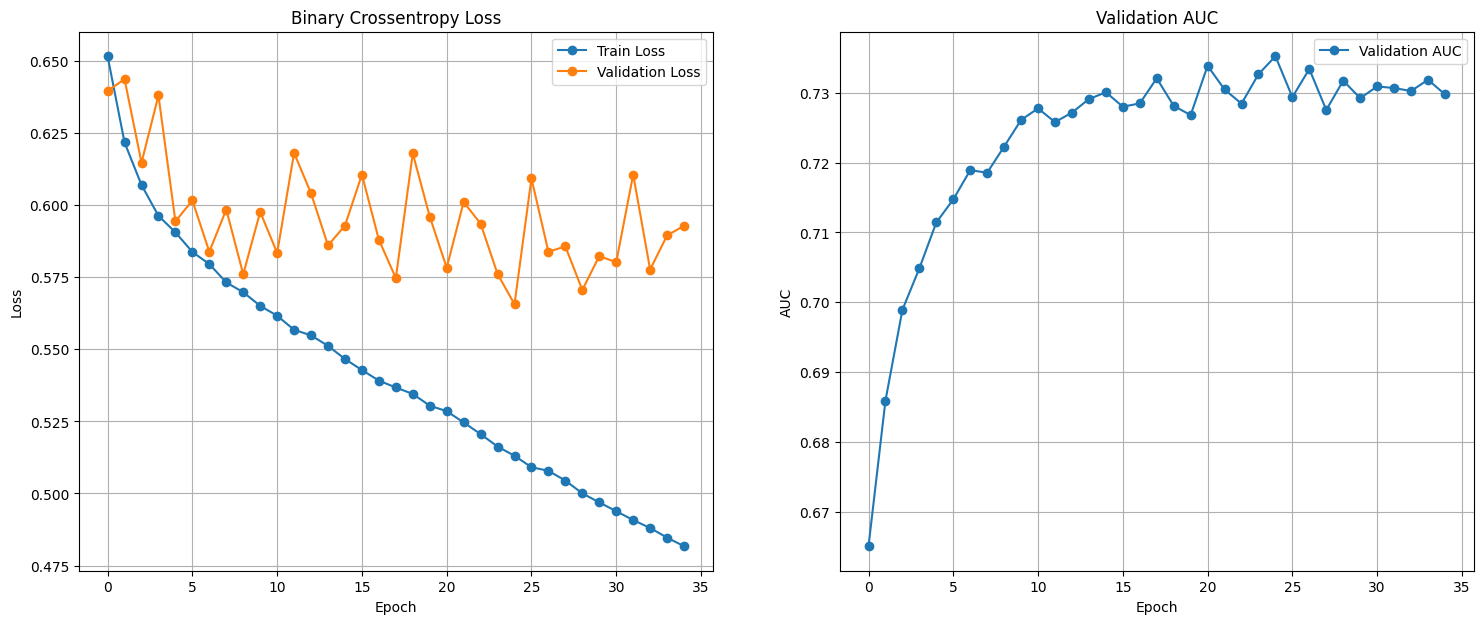


--- Pipeline complete. All outputs saved in 'output_conformer_training_tpu' directory. ---


In [ ]:
print("\nEvaluating Model on the Test Set")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n Classification Report (5 Stuttering Classes) ")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\nGenerating plots for model training history")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")


Evaluating Model on the Test Set


I0000 00:00:1753186774.838753      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14268929236901465428
E0000 00:00:1753186774.849145      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753186774.888674     827 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13118980879324891892), session_name()
I0000 00:00:1753186775.141103     827 tpu_compile_op_common.cc:245] Compilation of 13118980879324891892 with session name  took 252.355905ms and succeeded
I0000 00:00:1753186775.142220     827 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13118980879324891892), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14268929236901465428", property.function_library_fingerprint = 7187453517717651719, property.mlir_mo

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

I0000 00:00:1753186780.090877      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9317049762037504726
I0000 00:00:1753186780.213955     769 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4604234065359112112), session_name()
I0000 00:00:1753186780.676040     769 tpu_compile_op_common.cc:245] Compilation of 4604234065359112112 with session name  took 462.023442ms and succeeded
I0000 00:00:1753186780.677106     769 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4604234065359112112), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9317049762037504726", property.function_library_fingerprint = 10710389630097756697, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topolo

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step

 Classification Report (5 Stuttering Classes) 
              precision    recall  f1-score   support

Prolongation       0.64      0.55      0.59      2613
       Block       0.64      0.24      0.35      3501
    SoundRep       0.71      0.26      0.38      1891
     WordRep       0.49      0.53      0.51      1742
Interjection       0.91      0.53      0.67      3344

   micro avg       0.68      0.42      0.52     13091
   macro avg       0.68      0.42      0.50     13091
weighted avg       0.70      0.42      0.51     13091
 samples avg       0.56      0.44      0.46     13091


Generating plots for model training history


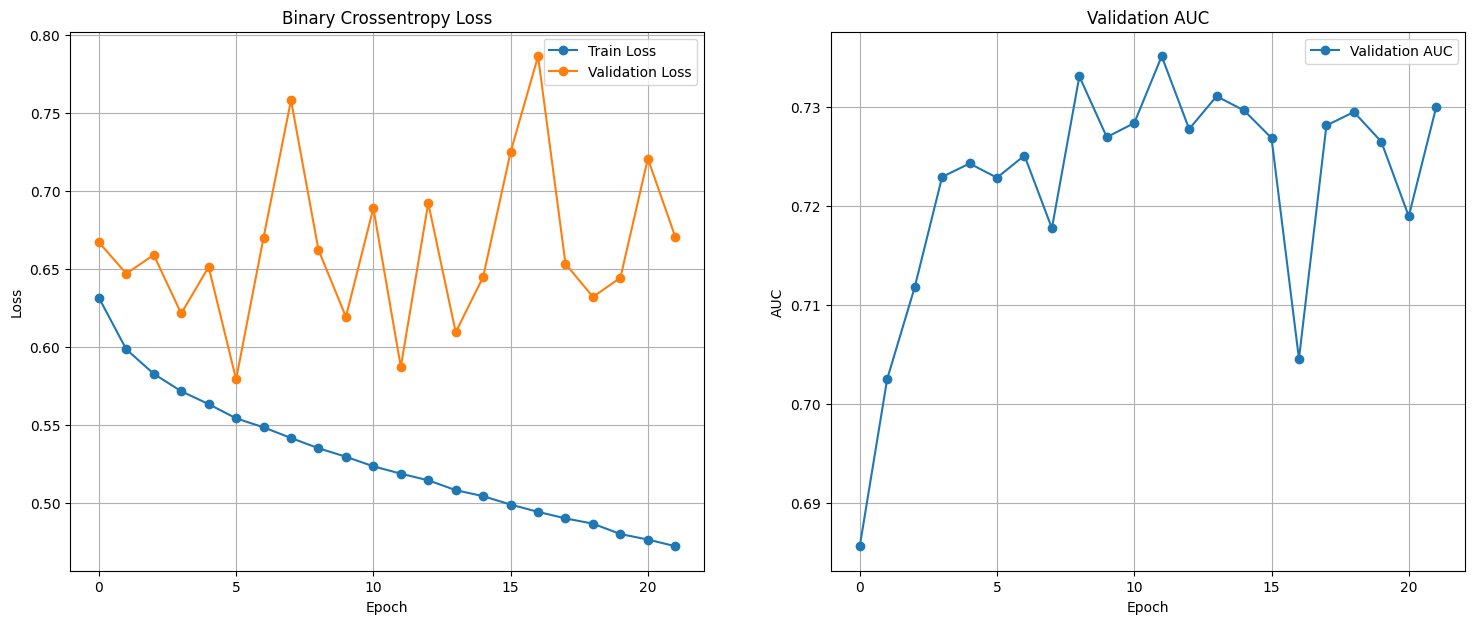


--- Pipeline complete. All outputs saved in '.' directory. ---


In [ ]:
print("\nEvaluating Model on the Test Set")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n Classification Report (5 Stuttering Classes) ")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# Plotting History 
print("\nGenerating plots for model training history")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
# plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")